# Chargement des données preprocessées

In [9]:
%matplotlib inline
import pickle as pk
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import roc_curve, auc, plot_confusion_matrix
from fonction import kpi, plot_auc, Mise_enforme, mat_conf2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
np.seterr(divide='ignore', invalid='ignore')

couleur = Mise_enforme()
pal = [couleur.lkp_green,couleur.lkp_blue,couleur.lkp_magenta,couleur.lkp_comp_blue,couleur.lkp_grey]

save_X_train = "data/X_train.pkl"
save_X_test = "data/X_test.pkl"
save_target_train = "data/y_train.pkl"
save_target_test = "data/y_test.pkl"

with open(save_X_train, "rb") as f:
    X_train = pk.load(f)
with open(save_X_test, "rb") as f:
    X_test = pk.load(f)
with open(save_target_train, "rb") as f:
    y_train = pk.load(f)
with open(save_target_test, "rb") as f:
    y_test = pk.load(f)


## Modélisation : recherche du meilleur modèle LGBM





- le paramètre `learning_rate` pondère les arbres créés.

- le paramètre `n_estimators` défini le nombre d'estimateur par arbre. 

- le paramètre `num_leaves` permet d'ajuster la précision tout en controlant le surapprentissage.
- le paramètre `boosting_type` défini le type d'arbre utilsé.
- le paramètre `max_bin` améliore la précision mais peut ralentir l'entrainement
- le praramètre `random_state` fixe le germe pour toute sélection aléatoire de features.
- le paramètre `max_depth` défini la profondeur maximale d'un arbre

In [10]:
t = y_train.drop(0,axis=0)
y_train

indexNames = y_train[ y_train == 0 ].index
# Delete these row indexes from dataFrame
t = y_train.drop(indexNames )#, inplace=True)
len(y_train)

6954

In [11]:
cv5 = StratifiedKFold(n_splits=5,
                      shuffle=True,
                      random_state=1759)
params = {
    'application': 'binary', 
    'boosting': 'gbdt', 
    'num_iterations': 100, 
    'learning_rate': 0.05,
    'num_leaves': 62,
    'max_depth': -1, 
    'max_bin': 510, 
    'metric' : 'accuracy',
    'subsample_for_bin': 200, 
    'subsample': 1, 
    'min_split_gain': 0.5, 
    'min_child_weight': 1, 
    'min_child_samples': 5
}

# Initialisation du classifieur
clf = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = -1, 
          max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'])



gridParams = {
    'learning_rate': np.arange(0.2,0.4,0.02),
    'n_estimators': [40,45,50,55,60],
    'num_leaves': [5,6,8],
    'boosting_type' : ['gbdt', 'dart'], 
    'objective' : ['binary'],
    'max_bin':[70,80,100,150,200], 
    'random_state' : [1759],
    'colsample_bytree' : np.arange(0.6,0.7,0.02),
    'subsample' : np.arange(0.56,0.7,0.02),
    'max_depth': [4, 5, 8,10]

    }

grid = GridSearchCV(clf, 
                    gridParams, 
                   #verbose=1, 
                    cv=cv5, 
                    n_jobs=-1)

# apprentissage
grid.fit(X_train, y_train)

clf_lgb = grid.best_estimator_

## Sauvegarde du modèle

Le meilleur estimateur logistique obtenue par validation croisée est sauvegardée pour être réutilisé plutard lors de la comparaison avec d'autres familles d'estimateur. Pour ce dernier, 
nous avons les paramètres suivants :

In [12]:
save_model_lgb = "modele/clf_lgb.pkl"

with open(save_model_lgb,"wb")as f:
    pk.dump(clf_lgb,f)
grid.best_params_

# {'boosting_type': 'dart',
#  'colsample_bytree': 0.63,
#  'learning_rate': 0.31999999999999995,
#  'max_bin': 80,
#  'max_depth': 8,
#  'n_estimators': 45,
#  'num_leaves': 8,
#  'objective': 'binary',
#  'random_state': 1759,
#  'subsample': 0.58}

{'boosting_type': 'dart',
 'colsample_bytree': 0.64,
 'learning_rate': 0.31999999999999995,
 'max_bin': 70,
 'max_depth': 8,
 'n_estimators': 55,
 'num_leaves': 8,
 'objective': 'binary',
 'random_state': 1759,
 'subsample': 0.56}

### Prédiction

Nous faisons ensuite quelques prédictions sur les échantillons splités : X_train et X_test.

In [13]:
y_pred_test = clf_lgb.predict(X_test)
probs_test = clf_lgb.predict_proba(X_test)

y_pred_train = clf_lgb.predict(X_train)
probs_train = clf_lgb.predict_proba(X_train)

### Evaluation du modèle 
Le taux de bonne prédictions (`accuracy`) d'un modèle est une métrique souvent utilisée en classification et correspond au nombre d'éléements bien classés sur le nombre total d'obsevations. Pour notre problématique, nous obtenons le score ci-dessous : 

In [14]:
kpi(clf_lgb,X_train,X_test,y_train,y_test,5)


#random forest : accuracy sur train 0.8 +/- 0.01
#random forest : accuracy sur test  0.79 +/- 0.03

Moyenne du score obtenus
random forest : accuracy sur train 0.8 +/- 0.01
random forest : accuracy sur test  0.78 +/- 0.02


# Matrice de confusion

Cet indicateur permet de calculer une série de KPI dont l'interpretation est fonction du problème étudié. Dans le cadre de ce challenge, nous nous limiterons à calculer l'AUC de chaque modèle.

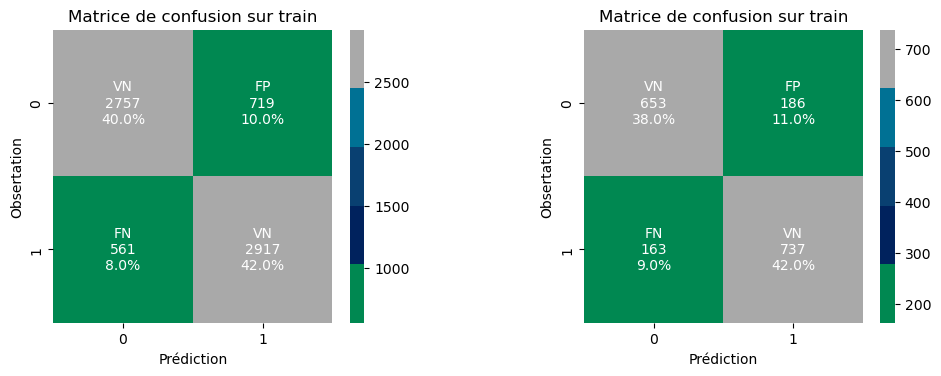

In [15]:
mat_conf2(y_train, y_pred_train,y_test, y_pred_test,pal)


# Calcul de l'AUC sur les données X_train et X_test

L'aire sous la courbe ROC (ou Area Under the Curve, AUC) peut être interprétée comme la probabilité que, parmi deux sujets passagers au hasard, un passager transporté dans une autre dimenssion et un non-transporté, la valeur du marqueur soit plus élevée pour celui transporté que pour le non-transporté. Par conséquent, une AUC de 0,5 (50%) indique que le marqueur est non-informatif. Une augmentation de l'AUC indique une amélioration des capacités discriminatoires, avec un maximum de 1. Plus nous sommes proches de 1, meilleur est le modèle. 

La valeur de l'AUC est de : 0.9030299197785059
La valeur de l'AUC est de : 0.8825665474771553


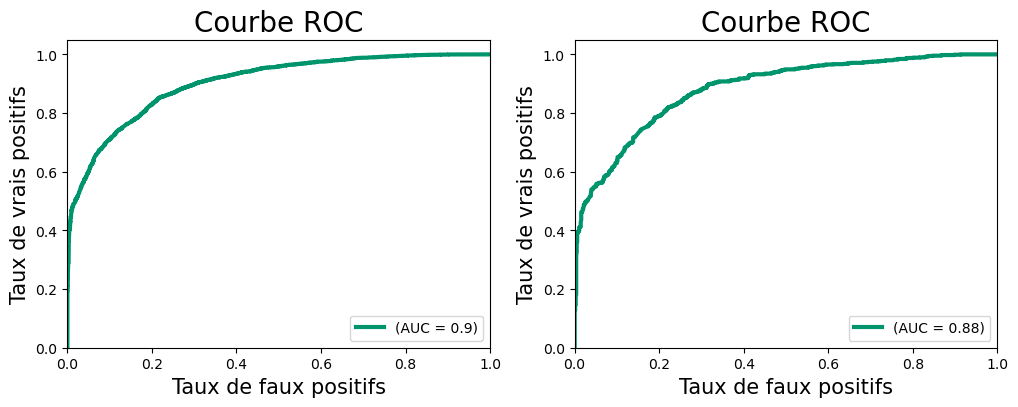

In [16]:
fig = plt.figure(figsize=(12,4))
plot_auc(y_train, probs_train,1,fig)

plot_auc(y_test, probs_test,2,fig)

#La valeur de l'AUC est de : 0.9022776571591546
#La valeur de l'AUC est de : 0.8825658853132035